In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
# from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import os
import json
import numpy as np
import csv
import pandas as pd
import math
import numpy as np
import glob
import tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from tqdm import tqdm
import sklearn
from sklearn.metrics import accuracy_score

import seaborn as sns
sns.set_theme(style="ticks")

import torchvision
from torchvision.io import read_image

# from sdtw_cuda_loss import SoftDTW

In [3]:
device = torch.device('cuda:0') #  if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [4]:
# target_folder = './extracted/mwd/nopims/'
target_folder = '/home/sharifullina/thesis/TIME/extracted/mwd/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/volve/'
# target_folder = '/Users/ramilasarifullina/Desktop/extracted/well_logs/nopims/'

### Выгрузим датасет Volve и преобразуем данные

In [5]:
wells = os.listdir(target_folder)
required_params_plus = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA', 'WELL']
required_params = ['DEPTH', 'ROPA', 'HKLA', 'WOB', 'SPPA']

logs = [json.load(open(os.path.join(target_folder, wells[i]), 'r')) for i in range(len(wells))]

In [6]:
# X_all - Dataframe with all logging while drilling data concatenated

dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
for i in range(len(dataset_all)):
    dataset_all[i]['WELL'] = wells[i]

dataset = []
for df in dataset_all:
    dataset.append(df[required_params_plus])
    
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

# X_list is a list containing a data for all wells splitted to windows with size 256

X_list = []
for i in range(0, len(X_all) - 256, 10):
    X_list.append(X_all[i : 256 + i])

    
# X_list_minus is X_list but without the WELL column
    
X_list_minus = []
for x in X_list:
    X_list_minus.append(x.loc[:, x.columns != 'WELL'])

X_verif_list = X_list_minus
    
# X is an array with the shape = (5901, 256, 5)
    
X = []
for i in X_list_minus:
    X.append(i.values)

X = np.dstack(X)
X = np.rollaxis(X, -1)

# map_well_to_label is dictionary to help to rename wells from 'well_N' to N
map_well_to_label = {w:i for i, w in enumerate(wells)}

# label = well's number
y = np.array([map_well_to_label[df['WELL'].iloc[0]] for df in X_list])


### Импортируем verificator, regulator

In [7]:
from dataset import Main_dataset, Verification_dataset
from models_new import * # GAN model
from inceptiontime.src.models.inception import InceptionModel # Verificator
# Regulator
from time_series_metrics.ssim_loss import SSIM_1d_conv
from time_series_metrics.tsfresh_loss import Mean_similarity_loss, Root_mean_square_similarity_loss, Coisine_between_angles_loss, Pearson_corr_funct_loss, Eucledian_distance_loss


### Загрузим датасет GAN

In [8]:
torch_dataset = Main_dataset(X, y, sparse_rate=1)
all_loader = DataLoader(torch_dataset, batch_size=64, shuffle=True)

In [9]:
train_n = 5310
train_set, val_set = torch.utils.data.random_split(torch_dataset, [train_n, len(torch_dataset) - train_n])

In [10]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

### Cоздадим датасет для верификатора и загрузим его

In [11]:
# соеденим все логи скважин в один большой pandas.DaraFrame
dataset_all = [pd.DataFrame(logs[i]['data'], columns=[x['name'] for x in logs[i]['curves']]) for i in range(len(logs))]
dataset = []
for df in dataset_all:
    dataset.append(df[required_params])
X_all = dataset[0]
for i in range(1, len(dataset)):
    X_all = pd.concat([X_all, dataset[i]], ignore_index = True)
X_all = X_all.ffill().bfill()

similar_wells = []

for i in range(0, 18400, 20):
    similar_wells.append(X_all[i : 256 + i])
# преобразуем лист в массив с размерностью [20, 256, 5]; 20 - количество скважин, 256 - размерность окна, 
#                                                   5 - количество столбцов = len(required_params)
similar_wells = np.dstack(similar_wells)
similar_wells = np.rollaxis(similar_wells, -1)

import random
different_wells = []

for i in range(0, 256 * 230, 256):
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])
    different_wells.append(X_all[i : i + 256])

random.shuffle(different_wells)
different_wells = np.dstack(different_wells)
different_wells = np.rollaxis(different_wells, -1)

needed = []
for i in range(different_wells.shape[0]):
    needed.append([different_wells[i - 1], different_wells[i], 1])
    needed.append([similar_wells[i - 1], similar_wells[i], 0])

In [12]:
verif_dataset = Verification_dataset(needed)
verif_loader = DataLoader(verif_dataset, batch_size=64, shuffle=True)

In [13]:
# check
for time1, time2, label in verif_loader:
    print(time1.shape)
    print(time2.shape)
    print(label)
    break

torch.Size([64, 5, 256])
torch.Size([64, 5, 256])
tensor([1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 1.])


### Train verification model

In [14]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                       out_channels=30,
                       bottleneck_channels=12, kernel_sizes=15,
                       use_residuals=True, 
                       num_pred_classes=len(wells)).to(device)

optimizer_verification = torch.optim.Adam(model_verification.parameters(), lr=1e-3)

In [15]:
class VerificationLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(VerificationLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

criterion_verification = VerificationLoss()

In [16]:
################################# TRAINING VERIFICATION #################################
def train_verification():
    best_train_acc = 0
    train_loss = []
    train_acc = []
    num_epochs = 100
    patience_counter = 0
    best_state_dict = None

    for epoch in range(num_epochs):
        model_verification.train();
        epoch_train_loss = []
        all_preds = []
        all_y = []
        for time1, time2, label in verif_loader:
            time1 = time1.to(device)
            time2 = time2.to(device)
            label = label.to(device)
            optimizer_verification.zero_grad()
            encoded_1 = model_verification(time1) 
            encoded_2 = model_verification(time2)
            loss = criterion_verification(encoded_1, encoded_2, label)
            epoch_train_loss.append(loss.item())
            loss.backward()
            optimizer_verification.step()
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Loss V: {loss.item():.4f}")
        train_loss.append(np.mean(epoch_train_loss))


    plt.plot(train_loss, label = 'train loss')
    plt.legend()
    plt.grid()
    plt.title('Mean loss inception score')
    plt.show()

    torch.save({
        'model_state_dict': model_verification.state_dict(),
    }, 
        'trained_models/model_verification.pt'
    )
    
# train_verification()

In [17]:
model_verification = InceptionModel(num_blocks=2, in_channels=len(required_params), 
                                    out_channels=30,
                                    bottleneck_channels=12, kernel_sizes=15,
                                    use_residuals=True, 
                                    num_pred_classes=len(wells)).to(device)
checkpoint = torch.load('trained_models/model_verification.pt')
model_verification.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Training models

In [18]:
# GANs hyperparamters
lr = 3e-4
batch_size = 128
num_epochs = 300
n_noise = 256
n_critic = 1
fixed_noise = torch.randn((batch_size, len(required_params), 256)).to(device)

In [19]:
disc_ms = Discriminator().to(device)
gen_ms = Generator().to(device)
disc_ms_osl = Discriminator().to(device)
gen_ms_osl = Generator().to(device)

disc_rms = Discriminator().to(device)
gen_rms = Generator().to(device)
disc_rms_osl = Discriminator().to(device)
gen_rms_osl = Generator().to(device)

disc_cba = Discriminator().to(device)
gen_cba = Generator().to(device)
disc_cba_osl = Discriminator().to(device)
gen_cba_osl = Generator().to(device)

disc_pcf = Discriminator().to(device)
gen_pcf = Generator().to(device)
disc_pcf_osl = Discriminator().to(device)
gen_pcf_osl = Generator().to(device)

disc_ed = Discriminator().to(device)
gen_ed = Generator().to(device)
disc_ed_osl = Discriminator().to(device)
gen_ed_osl = Generator().to(device)

disc_ssim = Discriminator().to(device)
gen_ssim = Generator().to(device)
disc_ssim_osl = Discriminator().to(device)
gen_ssim_osl = Generator().to(device)

criterion_gan_ms = nn.BCELoss()
criterion_gan_ms_osl = nn.BCELoss()

criterion_gan_rms = nn.BCELoss()
criterion_gan_rms_osl = nn.BCELoss()

criterion_gan_cba = nn.BCELoss()
criterion_gan_cba_osl = nn.BCELoss()

criterion_gan_pcf = nn.BCELoss()
criterion_gan_pcf_osl = nn.BCELoss()

criterion_gan_ed = nn.BCELoss()
criterion_gan_ed_osl = nn.BCELoss()

criterion_gan_ssim = nn.BCELoss()
criterion_gan_ssim_osl = nn.BCELoss()

D_opt_ms = torch.optim.Adam(disc_ms.parameters(), lr = lr)
G_opt_ms = torch.optim.Adam(gen_ms.parameters(), lr = lr)
D_opt_ms_osl = torch.optim.Adam(disc_ms_osl.parameters(), lr = lr)
G_opt_ms_osl = torch.optim.Adam(gen_ms_osl.parameters(), lr = lr)

D_opt_rms = torch.optim.Adam(disc_rms.parameters(), lr = lr)
G_opt_rms = torch.optim.Adam(gen_rms.parameters(), lr = lr)
D_opt_rms_osl = torch.optim.Adam(disc_rms_osl.parameters(), lr = lr)
G_opt_rms_osl = torch.optim.Adam(gen_rms_osl.parameters(), lr = lr)

D_opt_cba = torch.optim.Adam(disc_cba.parameters(), lr = lr)
G_opt_cba = torch.optim.Adam(gen_cba.parameters(), lr = lr)
D_opt_cba_osl = torch.optim.Adam(disc_cba_osl.parameters(), lr = lr)
G_opt_cba_osl = torch.optim.Adam(gen_cba_osl.parameters(), lr = lr)

D_opt_pcf = torch.optim.Adam(disc_pcf.parameters(), lr = lr)
G_opt_pcf = torch.optim.Adam(gen_pcf.parameters(), lr = lr)
D_opt_pcf_osl = torch.optim.Adam(disc_pcf_osl.parameters(), lr = lr)
G_opt_pcf_osl = torch.optim.Adam(gen_pcf_osl.parameters(), lr = lr)

D_opt_ed = torch.optim.Adam(disc_ed.parameters(), lr = lr)
G_opt_ed = torch.optim.Adam(gen_ed.parameters(), lr = lr)
D_opt_ed_osl = torch.optim.Adam(disc_ed_osl.parameters(), lr = lr)
G_opt_ed_osl = torch.optim.Adam(gen_ed_osl.parameters(), lr = lr)

D_opt_ssim = torch.optim.Adam(disc_ssim.parameters(), lr = lr)
G_opt_ssim = torch.optim.Adam(gen_ssim.parameters(), lr = lr)
D_opt_ssim_osl = torch.optim.Adam(disc_ssim_osl.parameters(), lr = lr)
G_opt_ssim_osl = torch.optim.Adam(gen_ssim_osl.parameters(), lr = lr)

### training the model

In [20]:
def train(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator,
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic):
    
    de_ident_rate_list = []
    simil_index = 0

    G_losses = []
    D_losses = []
    R_losses = []
    V_losses = []
    V_losses2 = []
    verificator_labels = []
    verificator_preds = []

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        for idx, data_all in enumerate(loader):
            # data preprocessing
            step = 0
            real_data, y = data_all
            real_data, y = real_data.to(device), y.to(device)
            batch_size = real_data.size(0)

            # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
            gen.eval()
            disc.train()
            D_opt.zero_grad()

            fake = gen(real_data)
            disc_real = disc(real_data)        
            D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake)
            D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            
            # verificator loss
            model_verification.eval()
            embeding_fake = model_verification(fake)
            embeding_real = model_verification(real_data)
            label = torch.ones(batch_size).to(device)
            loss_verif = criterion_verification(embeding_real, embeding_fake, label)
            V_losses.append(loss_verif.item())
            
            # de-identification rate
            pred_equal_y = torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]).to(device)
            pred_max = torch.max(embeding_fake, dim = 1)[0]
            de_ident_rate_list.append((pred_equal_y < pred_max).float().mean())
            
            # similarity loss
            if criterion_regulator != Eucledian_distance_loss:
                loss_regul = criterion_regulator()(real_data, fake)
            else:
                loss_regul = criterion_regulator()(real_data, fake) / 1000
            R_losses.append(loss_regul.item())
            
            D_loss = (D_loss_1 + D_loss_2) / 2 + 0.1 * loss_verif.detach() + 0.1 * loss_regul.detach()
            D_losses.append(D_loss.item())
            D_loss.backward() # retain_graph = True
            D_opt.step()
            
            # GENERATOR TRAINING == maximize D(G(noise))
            gen.train()
            disc.eval()
            G_opt.zero_grad()

            fake = gen(real_data)
            output = disc(fake)
            G_loss = criterion_gan(output, torch.ones_like(output))
            G_losses.append(G_loss.item())
            G_loss.backward() 
            G_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}, Loss V: {loss_verif.item():.4f}, Loss R: {loss_regul.item():.4f}")


            step += 1
            
    de_ident_rate = (sum(de_ident_rate_list) / len(de_ident_rate_list)).item()
    str_simil = 1 - sum(R_losses) / len(R_losses)
                    
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'de_ident_rate': de_ident_rate,
        'str_simil': str_simil
    }, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses, V_losses2

In [21]:
def train_osl(loader, 
          gen, 
          disc, 
          criterion_gan, 
          G_opt, 
          D_opt, 
          model_verification, 
          criterion_verification, 
          criterion_regulator,
          save_PATH, 
          lr, batch_size, num_epochs, n_noise, n_critic):
    
    de_ident_rate_list = []
    simil_index = 0

    G_losses = []
    D_losses = []
    R_losses = []
    V_losses = []
    verificator_labels = []
    verificator_preds = []

    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        for idx, data_all in enumerate(loader):
            # data preprocessing
            step = 0
            real_data, y = data_all
            real_data, y = real_data.to(device), y.to(device)
            batch_size = real_data.size(0)

            # DISCRIMINATOR TRAINING == maximize D(real_data) + (1 - D(G(noise)))
            gen.eval()
            disc.train()
            D_opt.zero_grad()

            fake = gen(real_data)
            disc_real = disc(real_data)        
            D_loss_1 = criterion_gan(disc_real, torch.full((disc_real.shape), 0.9).to(device))
            disc_fake = disc(fake)
            D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
            
            # verificator loss
            model_verification.eval()
            embeding_fake = model_verification(fake)
            embeding_real = model_verification(real_data)
            label = torch.ones(batch_size).to(device)
            loss_verif = criterion_verification(embeding_real, embeding_fake, label)
            V_losses.append(loss_verif.item())
            
            # de-identification rate
            pred_equal_y = torch.tensor([embeding_fake[i, y[i] - 1].item() for i in range(len(y))]).to(device)
            pred_max = torch.max(embeding_fake, dim = 1)[0]
            de_ident_rate_list.append((pred_equal_y < pred_max).float().mean())
            
            # similarity loss
            if criterion_regulator != Eucledian_distance_loss:
                loss_regul = criterion_regulator()(real_data, fake)
            else:
                loss_regul = criterion_regulator()(real_data, fake) / 1000
            R_losses.append(loss_regul.item())
            
            D_loss = (D_loss_1 + D_loss_2) / 2 + 0.1 * loss_verif.detach() + 0.1 * loss_regul.detach()
            D_losses.append(D_loss.item())
            D_loss.backward() 
            D_opt.step()
            
            # GENERATOR TRAINING == maximize D(G(noise))
            gen.train()
            disc.eval()
            G_opt.zero_grad()

            fake = gen(real_data)
            output = disc(fake)
            G_loss = criterion_gan(output, torch.full((output.shape), 0.9).to(device))
            G_losses.append(G_loss.item())
            G_loss.backward() 
            G_opt.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(loader)} Loss D: {D_loss.item():.4f}, Loss G: {G_loss.item():.4f}, Loss V: {loss_verif.item():.4f}, Loss R: {loss_regul.item():.4f}")


            step += 1
            
    de_ident_rate = (sum(de_ident_rate_list) / len(de_ident_rate_list)).item()
    str_simil = 1 - sum(R_losses) / len(R_losses)
                    
    torch.save({
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'de_ident_rate': de_ident_rate,
        'str_simil': str_simil
    }, save_PATH)
    
    return G_losses, D_losses, R_losses, V_losses

---

### models training

In [22]:
losses_ms = train(loader = train_loader, 
                  gen = gen_ms, 
                  disc = disc_ms, 
                  criterion_gan = criterion_gan_ms, 
                  G_opt = G_opt_ms, 
                  D_opt = D_opt_ms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Mean_similarity_loss,
                  save_PATH = 'trained_models/gan_ms_tuned_300epochs.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/300] Batch 82/83 Loss D: 0.2835, Loss G: 8.8467, Loss V: 0.7689, Loss R: 0.2689
Epoch [10/300] Batch 82/83 Loss D: 0.0845, Loss G: 9.1361, Loss V: 0.4441, Loss R: 0.2618
Epoch [20/300] Batch 82/83 Loss D: 0.1137, Loss G: 10.4502, Loss V: 0.5876, Loss R: 0.2741
Epoch [30/300] Batch 82/83 Loss D: 0.1162, Loss G: 8.4658, Loss V: 0.8475, Loss R: 0.2955
Epoch [40/300] Batch 82/83 Loss D: 0.1162, Loss G: 10.8814, Loss V: 0.8136, Loss R: 0.2941
Epoch [50/300] Batch 82/83 Loss D: 0.1207, Loss G: 12.7930, Loss V: 0.8406, Loss R: 0.3346
Epoch [60/300] Batch 82/83 Loss D: 0.1650, Loss G: 11.5980, Loss V: 1.1101, Loss R: 0.3807
Epoch [70/300] Batch 82/83 Loss D: 0.1314, Loss G: 9.1392, Loss V: 0.9337, Loss R: 0.3772
Epoch [80/300] Batch 82/83 Loss D: 0.1492, Loss G: 8.4977, Loss V: 0.7796, Loss R: 0.3898
Epoch [90/300] Batch 82/83 Loss D: 0.1196, Loss G: 11.6144, Loss V: 0.8532, Loss R: 0.3412
Epoch [100/300] Batch 82/83 Loss D: 0.0931, Loss G: 12.0061, Loss V: 0.5680, Loss R: 0.3537
Epoc

In [23]:
gen_ms = Generator().to(device)
disc_ms = Discriminator().to(device)

checkpoint_ms = torch.load('trained_models/gan_ms_tuned_300epochs.pt')

gen_ms.load_state_dict(checkpoint_ms['gen_state_dict'])
disc_ms.load_state_dict(checkpoint_ms['disc_state_dict'])
de_ident_rate_ms = checkpoint_ms['de_ident_rate']
str_simil_ms = checkpoint_ms['str_simil']
print(de_ident_rate_ms)
print(str_simil_ms)

0.9483596682548523
0.6771526462815134


In [ ]:
losses_ms_osl = train_osl(loader = train_loader, 
                  gen = gen_ms_osl, 
                  disc = disc_ms_osl, 
                  criterion_gan = criterion_gan_ms_osl, 
                  G_opt = G_opt_ms_osl, 
                  D_opt = D_opt_ms_osl, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Mean_similarity_loss,
                  save_PATH = 'trained_models/gan_ms_osl_new.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

In [ ]:
gen_ms_osl = Generator().to(device)
disc_ms_osl = Discriminator().to(device)

checkpoint_ms_osl = torch.load('trained_models/gan_ms_osl.pt')

gen_ms_osl.load_state_dict(checkpoint_ms_osl['gen_state_dict'])
disc_ms_osl.load_state_dict(checkpoint_ms_osl['disc_state_dict'])
de_ident_rate_ms_osl = checkpoint_ms_osl['de_ident_rate']
str_simil_ms_osl = checkpoint_ms_osl['str_simil']
print(de_ident_rate_ms_osl)
print(str_simil_ms_osl)

### root_mean_square

In [20]:
losses_rms = train(loader = train_loader, 
                  gen = gen_rms, 
                  disc = disc_rms, 
                  criterion_gan = criterion_gan_rms, 
                  G_opt = G_opt_rms,  
                  D_opt = D_opt_rms, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Root_mean_square_similarity_loss,
                  save_PATH = 'trained_models/gan_rms_tuned.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

NameError: name 'train' is not defined

In [21]:
gen_rms = Generator().to(device)
disc_rms = Discriminator().to(device)

checkpoint_rms = torch.load('trained_models/gan_rms_osl.pt')

gen_rms.load_state_dict(checkpoint_rms['gen_state_dict'])
disc_rms.load_state_dict(checkpoint_rms['disc_state_dict'])
de_ident_rate_rms = checkpoint_rms['de_ident_rate']
str_simil_rms = checkpoint_rms['str_simil']
print(de_ident_rate_rms)
print(str_simil_rms)

0.9543716311454773
0.43814170443149936


In [ ]:
losses_rms_osl = train_osl(loader = train_loader, 
                  gen = gen_rms_osl, 
                  disc = disc_rms_osl, 
                  criterion_gan = criterion_gan_rms_osl, 
                  G_opt = G_opt_rms_osl,  
                  D_opt = D_opt_rms_osl, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Root_mean_square_similarity_loss,
                  save_PATH = 'trained_models/gan_rms_osl_new.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

In [ ]:
gen_rms_osl = Generator().to(device)
disc_rms_osl = Discriminator().to(device)

checkpoint_rms_osl = torch.load('trained_models/gan_rms_osl.pt')

gen_rms_osl.load_state_dict(checkpoint_rms_osl['gen_state_dict'])
disc_rms_osl.load_state_dict(checkpoint_rms_osl['disc_state_dict'])
de_ident_rate_rms_osl = checkpoint_rms_osl['de_ident_rate']
str_simil_rms_osl = checkpoint_rms_osl['str_simil']
print(de_ident_rate_rms_osl)
print(str_simil_rms_osl)

### coisine_between_angles

In [27]:
losses_cba = train(loader = train_loader, 
                  gen = gen_cba, 
                  disc = disc_cba, 
                  criterion_gan = criterion_gan_cba, 
                  G_opt = G_opt_cba, 
                  D_opt = D_opt_cba, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Coisine_between_angles_loss,
                  save_PATH = 'trained_models/gan_cba_tuned.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/200] Batch 82/83 Loss D: 0.7548, Loss G: 0.7654, Loss V: 0.4395, Loss R: -0.0331
Epoch [10/200] Batch 82/83 Loss D: 0.7650, Loss G: 0.7658, Loss V: 0.5688, Loss R: -0.0351
Epoch [20/200] Batch 82/83 Loss D: 0.7650, Loss G: 0.7659, Loss V: 0.5656, Loss R: -0.0416
Epoch [30/200] Batch 82/83 Loss D: 0.7627, Loss G: 0.7604, Loss V: 0.5064, Loss R: -0.0299
Epoch [40/200] Batch 82/83 Loss D: 0.7712, Loss G: 0.7601, Loss V: 0.5795, Loss R: -0.0315
Epoch [50/200] Batch 82/83 Loss D: 0.7535, Loss G: 0.7623, Loss V: 0.4702, Loss R: -0.0457
Epoch [60/200] Batch 82/83 Loss D: 0.7743, Loss G: 0.7681, Loss V: 0.6018, Loss R: -0.0133
Epoch [70/200] Batch 82/83 Loss D: 0.7497, Loss G: 0.7616, Loss V: 0.3997, Loss R: -0.0530
Epoch [80/200] Batch 82/83 Loss D: 0.7697, Loss G: 0.7608, Loss V: 0.5641, Loss R: -0.0349
Epoch [90/200] Batch 82/83 Loss D: 0.7662, Loss G: 0.7642, Loss V: 0.5136, Loss R: -0.0160
Epoch [100/200] Batch 82/83 Loss D: 0.7681, Loss G: 0.7577, Loss V: 0.5634, Loss R: -0.0348

In [22]:
gen_cba = Generator().to(device)
disc_cba = Discriminator().to(device)

checkpoint_cba = torch.load('trained_models/gan_cba_osl.pt')

gen_cba.load_state_dict(checkpoint_cba['gen_state_dict'])
disc_cba.load_state_dict(checkpoint_cba['disc_state_dict'])
de_ident_rate_cba = checkpoint_cba['de_ident_rate']
str_simil_cba = checkpoint_cba['str_simil']

In [ ]:
losses_cba_osl = train_osl(loader = train_loader, 
                  gen = gen_cba_osl, 
                  disc = disc_cba_osl, 
                  criterion_gan = criterion_gan_cba_osl, 
                  G_opt = G_opt_cba_osl, 
                  D_opt = D_opt_cba_osl, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Coisine_between_angles_loss,
                  save_PATH = 'trained_models/gan_cba_osl.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

In [ ]:
gen_cba_osl = Generator().to(device)
disc_cba_osl = Discriminator().to(device)

checkpoint_cba_osl = torch.load('trained_models/gan_cba_osl.pt')

gen_cba_osl.load_state_dict(checkpoint_cba_osl['gen_state_dict'])
disc_cba_osl.load_state_dict(checkpoint_cba_osl['disc_state_dict'])
de_ident_rate_cba_osl = checkpoint_cba_osl['de_ident_rate']
str_simil_cba_osl = checkpoint_cba_osl['str_simil']

### pearson_corr_funct

In [29]:
losses_pcf = train(loader = train_loader, 
                  gen = gen_pcf, 
                  disc = disc_pcf, 
                  criterion_gan = criterion_gan_pcf, 
                  G_opt = G_opt_pcf, 
                  D_opt = D_opt_pcf, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Pearson_corr_funct_loss,
                  save_PATH = 'trained_models/gan_pcf_tuned.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

Epoch [0/200] Batch 82/83 Loss D: 0.0583, Loss G: 5.0860, Loss V: 0.1777, Loss R: 0.0931
Epoch [10/200] Batch 82/83 Loss D: 0.1352, Loss G: 7.1356, Loss V: 0.8994, Loss R: 0.2879
Epoch [20/200] Batch 82/83 Loss D: 0.1165, Loss G: 4.8963, Loss V: 0.5863, Loss R: 0.4071
Epoch [30/200] Batch 82/83 Loss D: 0.3588, Loss G: 4.9558, Loss V: 1.5157, Loss R: 0.5790
Epoch [40/200] Batch 82/83 Loss D: 0.1731, Loss G: 8.6037, Loss V: 1.1704, Loss R: 0.5578
Epoch [50/200] Batch 82/83 Loss D: 0.0610, Loss G: 9.2357, Loss V: 0.1393, Loss R: 0.4646
Epoch [60/200] Batch 82/83 Loss D: 0.1542, Loss G: 8.7008, Loss V: 1.1924, Loss R: 0.3398
Epoch [70/200] Batch 82/83 Loss D: 0.1669, Loss G: 7.0831, Loss V: 1.1177, Loss R: 0.5024
Epoch [80/200] Batch 82/83 Loss D: 0.2263, Loss G: 6.8580, Loss V: 0.9266, Loss R: 0.5939
Epoch [90/200] Batch 82/83 Loss D: 0.1619, Loss G: 7.0450, Loss V: 1.0143, Loss R: 0.5759
Epoch [100/200] Batch 82/83 Loss D: 0.1900, Loss G: 7.8865, Loss V: 1.1820, Loss R: 0.4774
Epoch [110

In [23]:
gen_pcf = Generator().to(device)
disc_pcf = Discriminator().to(device)

checkpoint_pcf = torch.load('trained_models/gan_pcf_osl.pt')

gen_pcf.load_state_dict(checkpoint_pcf['gen_state_dict'])
disc_pcf.load_state_dict(checkpoint_pcf['disc_state_dict'])
de_ident_rate_pcf = checkpoint_pcf['de_ident_rate']
str_simil_pcf = checkpoint_pcf['str_simil']
print(de_ident_rate_pcf)
print(str_simil_pcf)

0.9579246640205383
0.5089586703702951


In [ ]:
# losses_pcf_osl = train_osl(loader = train_loader, 
#                   gen = gen_pcf_osl, 
#                   disc = disc_pcf_osl, 
#                   criterion_gan = criterion_gan_pcf_osl, 
#                   G_opt = G_opt_pcf_osl, 
#                   D_opt = D_opt_pcf_osl, 
#                   model_verification = model_verification, 
#                   criterion_verification = criterion_verification, 
#                   criterion_regulator = Pearson_corr_funct_loss,
#                   save_PATH = 'trained_models/gan_pcf_osl.pt', 
#                   lr = lr, 
#                   batch_size = batch_size, 
#                   num_epochs = num_epochs, 
#                   n_noise = n_noise, 
#                   n_critic = n_critic)

In [ ]:
gen_pcf_osl = Generator().to(device)
disc_pcf_osl = Discriminator().to(device)

checkpoint_pcf_osl = torch.load('trained_models/gan_pcf_osl.pt')

gen_pcf_osl.load_state_dict(checkpoint_pcf_osl['gen_state_dict'])
disc_pcf_osl.load_state_dict(checkpoint_pcf_osl['disc_state_dict'])
de_ident_rate_pcf_osl = checkpoint_pcf_osl['de_ident_rate']
str_simil_pcf_osl = checkpoint_pcf_osl['str_simil']
print(de_ident_rate_pcf_osl)
print(str_simil_pcf_osl)

### eucledian_distance

In [24]:
losses_ed = train(loader = train_loader, 
                  gen = gen_ed, 
                  disc = disc_ed, 
                  criterion_gan = criterion_gan_ed, 
                  G_opt = G_opt_ed, 
                  D_opt = D_opt_ed, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Eucledian_distance_loss,
                  save_PATH = 'trained_models/gan_ed_osl.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

NameError: name 'train' is not defined

In [25]:
gen_ed = Generator().to(device)
disc_ed = Discriminator().to(device)

checkpoint_ed = torch.load('trained_models/gan_ed_osl.pt')

gen_ed.load_state_dict(checkpoint_ed['gen_state_dict'])
disc_ed.load_state_dict(checkpoint_ed['disc_state_dict'])
de_ident_rate_ed = checkpoint_ed['de_ident_rate']
str_simil_ed = checkpoint_ed['str_simil']
print(de_ident_rate_ed)
print(str_simil_ed)

0.9507067203521729
0.7032805558320987


In [ ]:
losses_ed_osl = train_osl(loader = train_loader, 
                  gen = gen_ed_osl, 
                  disc = disc_ed_osl, 
                  criterion_gan = criterion_gan_ed_osl, 
                  G_opt = G_opt_ed_osl, 
                  D_opt = D_opt_ed_osl, 
                  model_verification = model_verification, 
                  criterion_verification = criterion_verification, 
                  criterion_regulator = Eucledian_distance_loss,
                  save_PATH = 'trained_models/gan_ed_osl.pt', 
                  lr = lr, 
                  batch_size = batch_size, 
                  num_epochs = num_epochs, 
                  n_noise = n_noise, 
                  n_critic = n_critic)

In [ ]:
gen_ed_osl = Generator().to(device)
disc_ed_osl = Discriminator().to(device)

checkpoint_ed_osl = torch.load('trained_models/gan_ed_osl.pt')

gen_ed_osl.load_state_dict(checkpoint_ed_osl['gen_state_dict'])
disc_ed_osl.load_state_dict(checkpoint_ed_osl['disc_state_dict'])
de_ident_rate_ed_osl = checkpoint_ed_osl['de_ident_rate']
str_simil_ed_osl = checkpoint_ed_osl['str_simil']
print(de_ident_rate_ed_osl)
print(str_simil_ed_osl)

### ssim

In [ ]:
# losses_ssim = train(loader = train_loader, 
#                     gen = gen_ssim, 
#                     disc = disc_ssim, 
#                     criterion_gan = criterion_gan_ssim, 
#                     G_opt = G_opt_ssim, 
#                     D_opt = D_opt_ssim, 
#                     model_verification = model_verification, 
#                     criterion_verification = criterion_verification, 
#                     criterion_regulator = SSIM_1d_conv,
#                     save_PATH = 'trained_models/gan_ssim.pt', 
#                     lr = lr, 
#                     batch_size = batch_size, 
#                     num_epochs = num_epochs, 
#                     n_noise = n_noise, 
#                     n_critic = n_critic)

In [ ]:
# gen_ssim = Generator().to(device)
# disc_ssim = Discriminator().to(device)

# checkpoint_ssim = torch.load('trained_models/gan_ssim.pt')

# gen_ssim.load_state_dict(checkpoint_ssim['gen_state_dict'])
# disc_ssim.load_state_dict(checkpoint_ssim['disc_state_dict'])
# de_ident_rate_ssim = checkpoint_ssim['de_ident_rate']
# str_simil_ssim = checkpoint_ssim['str_simil']

In [ ]:
# plt.figure(figsize=(10, 7))
# plt.plot(losses_ssim[0], label = 'G_losses')
# plt.plot(losses_ssim[1], label = 'D_losses')
# # plt.plot(losses_ssim[2], label = 'R_losses')
# # plt.plot(losses_ssim[3], label = 'V_losses')
# plt.legend()
# plt.grid()
# plt.show()

### Figure

In [26]:
reg_names = ['Mean_similarity_loss', 
             'Root_mean_square_similarity_loss', 
             'Coisine_between_angles_loss', 
             'Pearson_corr_funct_loss', 
             'Eucledian_distance_loss', 
#              'SSIM_1d_conv'
            ]

regul_loss_dict = dict.fromkeys(reg_names, [])
regul_loss_list = [Mean_similarity_loss, 
                   Root_mean_square_similarity_loss, 
                   Coisine_between_angles_loss,
                   Pearson_corr_funct_loss, 
                   Eucledian_distance_loss, 
#                    SSIM_1d_conv
                  ]


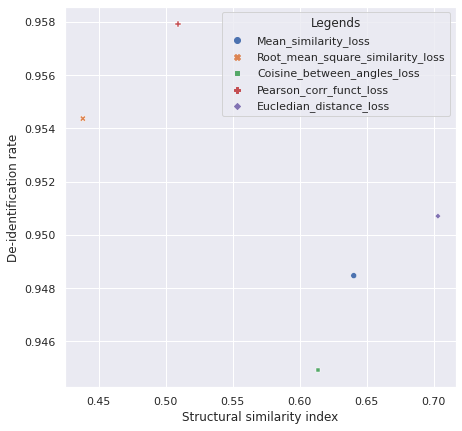

In [28]:
sns.set_theme()
data = pd.DataFrame({
    'Structural similarity index': [str_simil_ms, 
                                    str_simil_rms, 
                                    str_simil_cba, 
                                    str_simil_pcf, 
                                    str_simil_ed, 
#                                     str_simil_ssim
                                   ],
    'De-identification rate': [de_ident_rate_ms, 
                               de_ident_rate_rms, 
                               de_ident_rate_cba, 
                               de_ident_rate_pcf, 
                               de_ident_rate_ed, 
#                                de_ident_rate_ssim
                              ],
    'Legends': reg_names})

plt.figure(figsize = (7, 7))
sns.scatterplot(data=data, x="Structural similarity index", 
                y="De-identification rate", 
                hue = 'Legends', 
                style="Legends",
                legend='brief');
plt.savefig('images/GAN_window_256_trade_off_osl.png')


## test

In [25]:
scales_vectors = np.array([torch_dataset.feature_scales[f] for f in range(len(required_params))])

sparse_rate = torch_dataset.sparse_rate
print('sparse_rate', sparse_rate)
L = 64
print('L', L)
# window = L * sparse_rate
window = 256
print('window', window)
step = 4
print('step', step)

sparse_rate 1
L 64
window 256
step 4


In [26]:
test_well = wells[22]
test_well

'well_17.json'

In [27]:
X_test = pd.DataFrame(logs[22]['data'], columns=[x['name'] for x in logs[22]['curves']])
X_test = X_test[required_params]
X_test = X_test.drop_duplicates()

In [28]:
y_name = 'DEPTH'


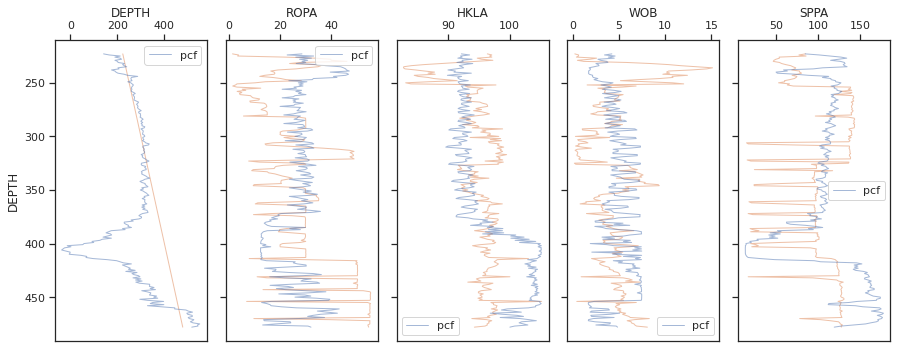

In [29]:
###################### CHECK ######################
t = X_test[y_name][:256].astype(float).values
x = X_test[required_params][:256].values

mean_x = x.mean(axis=0)
x = (x - mean_x) / scales_vectors
with torch.no_grad():
    x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
    z = gen_ms(x.transpose(1, 2))

z = z.transpose(1, 2)[0].cpu().data.numpy()*scales_vectors + mean_x

plt.figure(figsize=(15, 5))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)
    plt.plot(X_test[curve_name][:256].astype(float).values, t, lw=1, color='C1', alpha=0.5)
    plt.plot(z[:, i].astype(float), t, lw=1, color='C0', alpha=0.5, label = 'pcf')
    plt.legend()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')
plt.tight_layout()
# plt.savefig('images/window_256_ed_tuned.png')

In [78]:
def apply_window_transform(x, s, latent_noise_rate=0):
    x = x[np.arange(0, len(x), sparse_rate), :]
    mean_x = x.mean(axis=0)
    x = (x - mean_x)/s
    with torch.no_grad():
        x = torch.Tensor(x).view(1, x.shape[0], -1).to(device)
        z = gen_ed(x.transpose(1, 2))
    
    return z.transpose(1, 2)[0].cpu().data.numpy()*s + mean_x, z.transpose(1, 2)[0].cpu().data.numpy()

In [79]:
def apply_rolling_transform(X, w, scales, step=12):
    Z = []
    
    for i in tqdm(range(0, len(X) - w, step)):
        Z.append(apply_window_transform(X[i: i+w], scales))
        
    return Z

In [80]:
Z = apply_rolling_transform(X_test[required_params].values, window, scales_vectors, step)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 789/789 [00:02<00:00, 312.76it/s]


789it [00:00, 159723.24it/s]
/tmp/ipykernel_11379/1668424777.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
789it [00:00, 182090.12it/s]
/tmp/ipykernel_11379/1668424777.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
789it [00:00, 166791.28it/s]
/tmp/ipykernel_11379/1668424777.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
789it [00:00, 161327.25it/s]
/tmp/ipykernel_11379/1668424777.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)
789it [00:00, 160919.32it/s]
/tmp/ipykernel_11379/1668424777.py:14: RuntimeWarning: Mean of empty slice
  A = np.nanmean(A, axis=0)


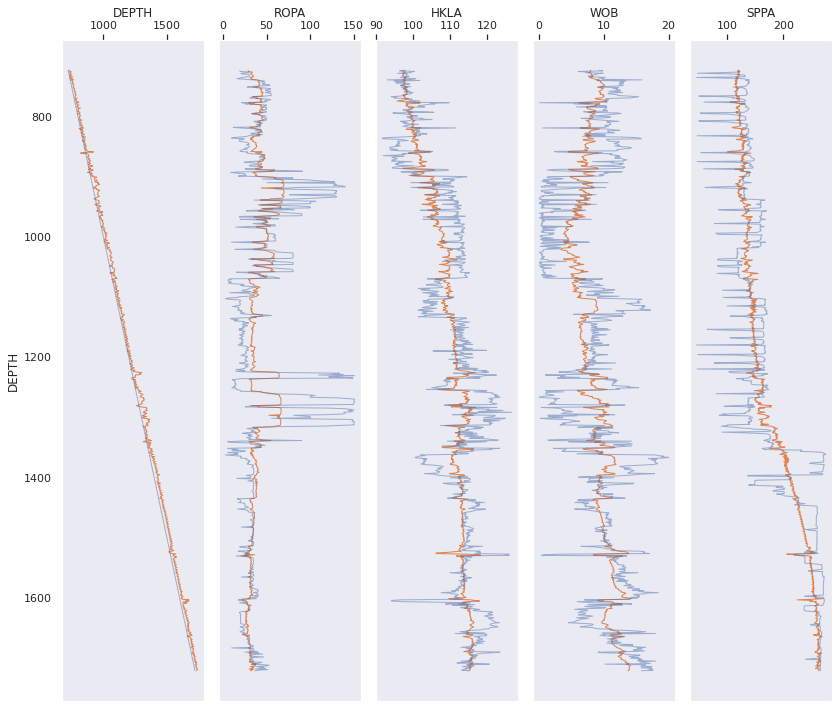

In [81]:
original = []
generated = []

t = X_test[y_name].astype(float).values
plt.figure(figsize=(14, 10))
for i, curve_name in enumerate(required_params):
    plt.subplot(1, len(df.columns) - 1, i + 1)

    zis = range(0, len(X_test) - window, step)
    A = np.zeros((len(zis), len(X_test))) * np.nan
    for zi, x in tqdm(enumerate(zis)):
        A[zi, np.arange(x, x+window, sparse_rate)] = Z[zi][0][:, i]
    
    A = np.nanmean(A, axis=0)
    not_nan_inds = np.where(~np.isnan(A))[0]
    
#     original.append(X_test[curve_name].astype(float).values)
#     generated.append(A[not_nan_inds])
    
    plt.plot(A[not_nan_inds][500:1500], t[not_nan_inds][500:1500], color='C1', lw=1)
    plt.plot(X_test[curve_name].astype(float).values[500:1500], t[500:1500], lw=1, color='C0', alpha=0.5)
    plt.grid()
    axis = plt.gca()
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top')
    if i > 0: axis.set_yticklabels([])

    if i == 0:
        plt.ylabel(f'{y_name}')
    plt.xlabel(f'{curve_name}')

plt.tight_layout()
plt.savefig('images/ED_tuned.png')

In [ ]:
# for i in required_params[:-1]:
#     sns.displot(data=df_some, 
#             x=i, hue='WELL', kind='kde',
#             fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5
#                )